# [SETI Breakthrough Listen - E.T. Signal Search](https://www.kaggle.com/c/seti-breakthrough-listen)
>Find extraterrestrial signals in data from deep space 

![](https://storage.googleapis.com/kaggle-competitions/kaggle/23652/logos/header.png?t=2021-02-24-19-15-30)

# Reference
Check this amazing notebook, [How To Create TFRecords](https://www.kaggle.com/cdeotte/how-to-create-tfrecords) by [Chris Deotte](https://www.kaggle.com/cdeotte)

# How to Create TFRecord

In [1]:
SEED  = 42
FOLDS = 20
DIM   = 256

# Importing Packages

In [2]:
import numpy as np 
import pandas as pd 
import os, shutil
from glob import glob
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder

In [3]:
train_label_df = pd.read_csv('../input/seti-breakthrough-listen/train_labels.csv')
test_label_df  = pd.read_csv('../input/seti-breakthrough-listen/sample_submission.csv')

In [4]:
train_paths = glob('../input/seti-breakthrough-listen/train/**/*.npy')
test_paths = glob('../input/seti-breakthrough-listen/test/**/*.npy')
len(train_paths), len(test_paths)

(60000, 39995)

In [5]:
train_df = pd.DataFrame({'filepath':train_paths})
train_df['id'] = train_df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
train_df['group'] = train_df.filepath.map(lambda x: x.split('/')[-2])
train_df = pd.merge(train_df, train_label_df, on='id', how='left')
train_df['group_target'] = train_df.group+train_df.target.astype(str)
train_df.head()

,filepath,id,group,target,group_target
0,../input/seti-breakthrough-listen/train/7/75f1...,75f189800cf94ab,7,0,70
1,../input/seti-breakthrough-listen/train/7/752b...,752b35e183865ec,7,0,70
2,../input/seti-breakthrough-listen/train/7/747d...,747d5a1f5ab25a9,7,0,70
3,../input/seti-breakthrough-listen/train/7/733e...,733ed45fba7f38c,7,0,70
4,../input/seti-breakthrough-listen/train/7/7c4f...,7c4f62430b3cb07,7,0,70


In [6]:
test_df = pd.DataFrame({'filepath':test_paths})
test_df['id'] = test_df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])
test_df['group'] = test_df.filepath.map(lambda x: x.split('/')[-2])
test_df.head()

,filepath,id,group
0,../input/seti-breakthrough-listen/test/7/79c3c...,79c3c2893d38a8d,7
1,../input/seti-breakthrough-listen/test/7/7acc5...,7acc5c0c2939ba5,7
2,../input/seti-breakthrough-listen/test/7/7073f...,7073f4f9a565cca,7
3,../input/seti-breakthrough-listen/test/7/7a345...,7a3457cbeda97ae,7
4,../input/seti-breakthrough-listen/test/7/7caba...,7caba20af3e8923,7


# Check The Data

In [7]:
train_df.target.value_counts()

0    54000
1     6000
Name: target, dtype: int64

In [8]:
train_df.group.value_counts()

a    3845
7    3842
9    3795
6    3779
5    3770
f    3769
d    3768
2    3758
8    3749
1    3749
b    3728
c    3720
0    3713
e    3680
3    3672
4    3663
Name: group, dtype: int64

In [9]:
train_df.groupby(['group','target'])['id'].count()

group  target
0      0         3327
       1          386
1      0         3354
       1          395
2      0         3392
       1          366
3      0         3305
       1          367
4      0         3282
       1          381
5      0         3371
       1          399
6      0         3417
       1          362
7      0         3440
       1          402
8      0         3394
       1          355
9      0         3409
       1          386
a      0         3493
       1          352
b      0         3347
       1          381
c      0         3354
       1          366
d      0         3399
       1          369
e      0         3281
       1          399
f      0         3435
       1          334
Name: id, dtype: int64

# Stratified KFold by Groups

In [10]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
train_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    train_df.loc[val_idx,'fold'] = fold
# train_df.groupby(['fold', 'target'])['id'].count()

# Check the signals
From the [dataset information](https://www.kaggle.com/c/seti-breakthrough-listen/overview/data-information),
>>
Not all of the “needle” signals look like diagonal lines, and they may not be present for the entirety of all three “A” observations, but what they do have in common is that they are only present in some or all of the “A” observations (panels **1**, **3**, and **5** in the cadence snippets).



In [11]:
import matplotlib.pyplot as plt, cv2

def load_signal(filepath, dim=DIM):
    sgnl = np.load(filepath)
    sgnl = sgnl[::2,] # we're taking only 1, 3, 5
    img  = np.moveaxis(sgnl, 0, -1)
    img  = img.astype(np.float32)
    if dim is not None:
        img = cv2.resize(img, dsize=(dim, dim), interpolation=cv2.INTER_NEAREST)
    return img

def visualize(sgnl):
    sgnl = sgnl.astype(float)
    plt.figure(figsize=(20, 10))
    for idx in range(3):
        plt.subplot(2, 6, idx+1)
        plt.imshow(sgnl[...,idx])
        plt.axis('OFF')
    plt.tight_layout()
    plt.show()

# Visualize Channels

## No Resize

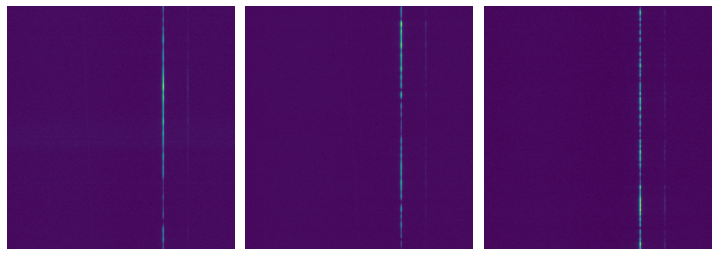

((273, 256, 3), dtype('float32'))

In [12]:
sgnl = load_signal(train_df[train_df.target==1].filepath.iloc[2], dim=None)
visualize(sgnl)
sgnl.shape, sgnl.dtype

# Resize

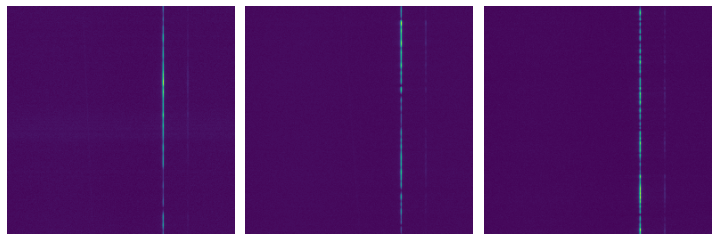

((256, 256, 3), dtype('float32'))

In [13]:
sgnl = load_signal(train_df[train_df.target==1].filepath.iloc[2], dim=DIM)
visualize(sgnl)
sgnl.shape, sgnl.dtype

# TFRecord Data

In [14]:
import tensorflow as tf

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Writng TFRecord (Train)

In [15]:
def train_serialize_example(feature0, feature1, feature2, feature3):
    feature = {
      'image'         : _bytes_feature(feature0),
      'image_id'      : _bytes_feature(feature1),
      'group'         : _bytes_feature(feature2),    
      'target'        : _int64_feature(feature3),
  }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [16]:
show=True
folds = train_df.fold.unique().tolist()
for fold in tqdm(folds): # create tfrecord for each fold
    fold_df = train_df[train_df.fold==fold]
    if show:
        print(); print('Writing TFRecord of fold %i :'%(fold))  
    with tf.io.TFRecordWriter('train%.2i-%i.tfrec'%(fold,fold_df.shape[0])) as writer:
        samples = fold_df.shape[0]
#         samples = 200
        it = tqdm(range(samples)) if show else range(samples)
        for k in it: # images in fold
            row = fold_df.iloc[k,:]
            image      = load_signal(row['filepath'], dim=DIM)
            image      = image[...,::-1] # rgb -> bgr, we'll get the rgb form after decoding the tfrec
            image_id   = row['id']
            group      = row['group']
            target     = np.array(row['target'], dtype=np.uint8)
            example  = train_serialize_example(
                cv2.imencode('.png', image)[1].tobytes(),
                str.encode(image_id),
                str.encode(group),
                target,
                )
            writer.write(example)
        if show:
            filepath = 'train%.2i-%i.tfrec'%(fold,fold_df.shape[0])
            filename = filepath.split('/')[-1]
            filesize = os.path.getsize(filepath)/10**6
            print(filename,':',np.around(filesize, 2),'MB')

  0%|          | 0/20 [00:00<?, ?it/s]


Writing TFRecord of fold 11 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train11-3000.tfrec : 62.09 MB

Writing TFRecord of fold 12 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train12-3000.tfrec : 61.33 MB

Writing TFRecord of fold 15 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train15-3000.tfrec : 61.89 MB

Writing TFRecord of fold 10 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train10-3000.tfrec : 62.55 MB

Writing TFRecord of fold 2 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train02-3000.tfrec : 61.98 MB

Writing TFRecord of fold 1 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train01-3000.tfrec : 60.68 MB

Writing TFRecord of fold 9 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train09-3000.tfrec : 61.89 MB

Writing TFRecord of fold 18 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train18-3000.tfrec : 61.58 MB

Writing TFRecord of fold 13 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train13-3000.tfrec : 61.51 MB

Writing TFRecord of fold 16 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train16-3000.tfrec : 62.12 MB

Writing TFRecord of fold 17 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train17-3000.tfrec : 61.06 MB

Writing TFRecord of fold 19 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train19-3000.tfrec : 61.64 MB

Writing TFRecord of fold 14 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train14-3000.tfrec : 61.04 MB

Writing TFRecord of fold 7 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train07-3000.tfrec : 62.75 MB

Writing TFRecord of fold 4 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train04-3000.tfrec : 62.39 MB

Writing TFRecord of fold 5 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train05-3000.tfrec : 61.08 MB

Writing TFRecord of fold 3 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train03-3000.tfrec : 61.2 MB

Writing TFRecord of fold 6 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train06-3000.tfrec : 61.55 MB

Writing TFRecord of fold 0 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train00-3000.tfrec : 61.92 MB

Writing TFRecord of fold 8 :


  0%|          | 0/3000 [00:00<?, ?it/s]

train08-3000.tfrec : 61.7 MB


# Writing TFRecord (Test)

In [17]:
def test_serialize_example(feature0, feature1, feature2):
    feature = {
      'image'         : _bytes_feature(feature0),
      'image_id'      : _bytes_feature(feature1),
      'group'         : _bytes_feature(feature2),    
  }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

In [18]:
show  = True
folds = 10
l     = int(np.ceil(test_df.shape[0]/folds))
for fold in tqdm(range(folds)): # create tfrecord for each fold
    fold_df = test_df.iloc[l*fold:l*(fold+1)]
    if show:
        print(); print('Writing TFRecord of fold %i :'%(fold))  
    with tf.io.TFRecordWriter('test%.2i-%i.tfrec'%(fold,fold_df.shape[0])) as writer:
        samples = fold_df.shape[0]
#         samples = 200
        it = tqdm(range(samples)) if show else range(samples)
        for k in it: # images in fold
            row = fold_df.iloc[k,:]
            image      = load_signal(row['filepath'], dim=DIM)
            image      = image[...,::-1] # rgb -> bgr, we'll get the rgb form after decoding the tfrec
            image_id   = row['id']
            group      = row['group']
            example  = test_serialize_example(
                cv2.imencode('.png', image)[1].tobytes(),
                str.encode(image_id),
                str.encode(group),
                )
            writer.write(example)
        if show:
            filepath = 'test%.2i-%i.tfrec'%(fold,fold_df.shape[0])
            filename = filepath.split('/')[-1]
            filesize = os.path.getsize(filepath)/10**6
            print(filename,':',np.around(filesize, 2),'MB')

  0%|          | 0/10 [00:00<?, ?it/s]


Writing TFRecord of fold 0 :


  0%|          | 0/4000 [00:00<?, ?it/s]

test00-4000.tfrec : 127.05 MB

Writing TFRecord of fold 1 :


  0%|          | 0/4000 [00:00<?, ?it/s]

test01-4000.tfrec : 128.21 MB

Writing TFRecord of fold 2 :


  0%|          | 0/4000 [00:00<?, ?it/s]

test02-4000.tfrec : 127.48 MB

Writing TFRecord of fold 3 :


  0%|          | 0/4000 [00:00<?, ?it/s]

test03-4000.tfrec : 127.8 MB

Writing TFRecord of fold 4 :


  0%|          | 0/4000 [00:00<?, ?it/s]

test04-4000.tfrec : 127.34 MB

Writing TFRecord of fold 5 :


  0%|          | 0/4000 [00:00<?, ?it/s]

test05-4000.tfrec : 128.02 MB

Writing TFRecord of fold 6 :


  0%|          | 0/4000 [00:00<?, ?it/s]

test06-4000.tfrec : 126.59 MB

Writing TFRecord of fold 7 :


  0%|          | 0/4000 [00:00<?, ?it/s]

test07-4000.tfrec : 127.55 MB

Writing TFRecord of fold 8 :


  0%|          | 0/4000 [00:00<?, ?it/s]

test08-4000.tfrec : 127.05 MB

Writing TFRecord of fold 9 :


  0%|          | 0/3995 [00:00<?, ?it/s]

test09-3995.tfrec : 127.36 MB


# Reading TFRecord

In [19]:
import re, math
def decode_image(image_data):
    image = tf.image.decode_png(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image
def prepare_target(target):    
    target = tf.cast(target, tf.float32)            
    target = tf.reshape(target, [1])         
    return target

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image" : tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "target": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    image  = tf.reshape(image, [DIM, DIM, 3])
    target = prepare_target(example['target'])
    return image, target # returns a dataset of (image, label) pairs

def load_dataset(fileids, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(fileids, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(20, seed=SEED)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(fileids):
    # the number of data items is written in the id of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(fileid).group(1)) for fileid in fileids]
    return np.sum(n)

# Visual

In [20]:
def display_batch(batch, size=2):
    imgs, tars = batch
    for img_idx in range(size):
        plt.figure(figsize=(4*2, 12*2))
        for idx in range(3):
            plt.subplot(size, 3, idx+1)
            plt.title(f'Target:{tars[img_idx].numpy()[0]}')
            plt.imshow(imgs[img_idx,:, :, idx])
            plt.text(5, 10, str(idx), bbox={'facecolor': 'white'})
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.show() 

# Total Images

In [21]:
# INITIALIZE VARIABLES
IMAGE_SIZE= [DIM,DIM];
BATCH_SIZE = 32
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('train*.tfrec')
TEST_FILENAMES     = tf.io.gfile.glob('test*.tfrec')
print('There are %i train & %i test images'%(count_data_items(TRAINING_FILENAMES), count_data_items(TEST_FILENAMES)))

There are 60000 train & 39995 test images


# Once Batch Image

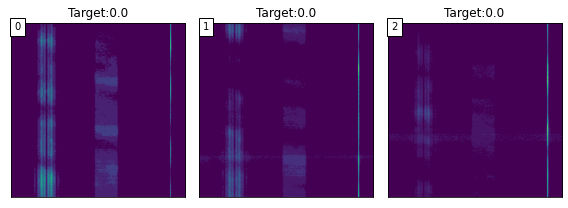

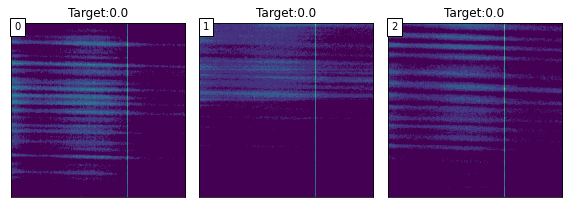

In [22]:
# DISPLAY TRAIN IMAGES
training_dataset = get_training_dataset()
training_dataset = training_dataset.unbatch().batch(20)
train_batch = next(iter(training_dataset))
display_batch(train_batch, 2);

In [23]:
img, label = train_batch
np.unique(label.numpy(), return_counts=True)

(array([0., 1.], dtype=float32), array([19,  1]))